In [56]:
import pandas as pd
import re
import nltk
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from functools import reduce

from my_functions import read_docx_tables as read_df, ha, listReader, delta, affinity, cossim

In [2]:
df = pd.read_csv('test_1.csv', encoding='utf-8', sep=';')
columns = ['First', 'Second', 'Third', 'TR_1', 'TR_2', 'TR_3', 'DELTA', 'Translate']
df = df[columns]

with open('vokab.pickle', 'rb') as f:
    vocab = pickle.load(f)
    
with open('vectors.pickle', 'rb') as f:
    vectors = pickle.load(f)
    
with open('id2f.pickle', 'rb') as f:
    id2f = pickle.load(f)
    
with open('f2id.pickle', 'rb') as f:
    f2id = pickle.load(f)

### test

In [3]:
kmeans = KMeans(n_clusters=20)

In [4]:
kmeans.fit(vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [5]:
kmeans.labels_

array([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7, 14,
        4,  4,  4,  4,  4,  4,  0,  0,  0,  0,  0,  0, 10, 10, 13,  8,  8,
       11,  1,  1,  9,  9, 12, 15,  5,  5, 15,  3, 16, 16, 19,  3, 17, 18,
       18], dtype=int32)

### test over

In [6]:
for i in range(3, 7):
    print(i)
    df[df.columns[i]] = df[df.columns[i]].apply(lambda x: listReader(x))

3
4
5
6


In [7]:
df[df.columns[6]][4]

[[''], [''], ['AH0', 'N']]

In [8]:
def norm_sum_of_vecs(arr: list) -> list:
    res = []
    cur = []
    for el in arr:
        cur = [0.0] * len(vectors[0])
        if el[0]:
            cur = [vectors[f2id[f]] for f in el]
            cur = norm_of_vecs(cur)
        res.append(cur)
    return res
        
def sum_of_vecs(arr1, arr2) -> list:
    if len(arr1) != len(arr2):
        print('len(arr1) != len(arr2)')
        return []
    res = [0.0] * len(arr1)
    for i in range(len(arr1)):
        res[i] = arr1[i] + arr2[i] 
    return res

def norm_of_vecs(vecs: list, dlt = 5) -> list:
    res = reduce(lambda a, b: sum_of_vecs(a, b), vecs)
    for i in range(len(res)):
        #res[i] /= float(len(vecs))
        res[i] = round(res[i] / float(len(vecs)), 5)
    return res

In [9]:
norm_of_vecs([[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [2.0, 2.0, 2.0]])

[1.33333, 1.33333, 1.33333]

In [10]:
list_of_vectorized_frame = [norm_sum_of_vecs(raw) for raw in df[df.columns[6]]]

In [13]:
print(len(list_of_vectorized_frame[0][0]), len(vectors[0]))

69 69


### clustering

In [14]:
n_clusters = range(3, int(len(list_of_vectorized_frame) * 0.7))

xy = []

xy_c = [[], [], []]

print('Test 1:')

best = (-1.0, -1)

for n in n_clusters:
    AVG = []
    for i in range(len(list_of_vectorized_frame[0])):
        clusterer = KMeans(n_clusters=n)
        data = [x[i] for x in list_of_vectorized_frame]
        cluster_labels = clusterer.fit_predict(data)

        silhouette_avg = silhouette_score(data, cluster_labels)
        AVG.append(silhouette_avg)
        print('\t\tsilhouette_avg for {0} list = {1}'.format(i, silhouette_avg))
    
    avg = sum(AVG) / len(AVG)
    if avg > best[0]:
        best = (avg, n)
    print('\tavg = {0}, current best = {1}: {2}'.format(avg, best[1], best[0]))
    
    xy.append((n, avg))
    
print('\nTest 2:')

best_by_column = [(-1.0, -1), (-1.0, -1), (-1.0, -1)]

for i in range(len(list_of_vectorized_frame[0])):
    print('\tcolumn {0}'.format(i))
    for n in n_clusters:
        clusterer = KMeans(n_clusters=n)
        data = [x[i] for x in list_of_vectorized_frame]
        cluster_labels = clusterer.fit_predict(data)

        silhouette_avg = silhouette_score(data, cluster_labels)
        if silhouette_avg > best_by_column[i][0]:
            best_by_column[i] = (silhouette_avg, n)
        print('\t\tsilhouette_avg for {0} list = {1}'.format(i, silhouette_avg))
        print('\t\tcurrent best = {0}: {1}'.format(best_by_column[i][1], best_by_column[i][0]))
        
        xy_c[i].append((n, silhouette_avg))
        
print()

print('best = {0}\nbest by column = {1}\n{2}\n{3}'.format(best, best_by_column[0], best_by_column[1], best_by_column[2])) 

Test 1:
		silhouette_avg for 0 list = 0.5984344247407486
		silhouette_avg for 1 list = 0.4899956255199891
		silhouette_avg for 2 list = 0.6031007741418607
	avg = 0.5638436081341994, current best = 3: 0.5638436081341994
		silhouette_avg for 0 list = 0.4711627077203363
		silhouette_avg for 1 list = 0.5789286218042068
		silhouette_avg for 2 list = 0.4441467170109839
	avg = 0.49807934884517563, current best = 3: 0.5638436081341994
		silhouette_avg for 0 list = 0.5246314962329134
		silhouette_avg for 1 list = 0.48647011006215707
		silhouette_avg for 2 list = 0.5037718979518825
	avg = 0.5049578347489843, current best = 3: 0.5638436081341994
		silhouette_avg for 0 list = 0.5433905727815732
		silhouette_avg for 1 list = 0.5602943755375511
		silhouette_avg for 2 list = 0.49223715167042315
	avg = 0.5319740333298492, current best = 3: 0.5638436081341994
		silhouette_avg for 0 list = 0.5409141125801787
		silhouette_avg for 1 list = 0.5408112660189502
		silhouette_avg for 2 list = 0.515041165505999

		silhouette_avg for 1 list = 0.8442381643623873
		silhouette_avg for 2 list = 0.7751077803239657
	avg = 0.824802701847038, current best = 42: 0.824802701847038
		silhouette_avg for 0 list = 0.8526064488423776
		silhouette_avg for 1 list = 0.8550187003496722
		silhouette_avg for 2 list = 0.7764274927896964
	avg = 0.8280175473272487, current best = 43: 0.8280175473272487
		silhouette_avg for 0 list = 0.8518987698229241
		silhouette_avg for 1 list = 0.8518760064662168
		silhouette_avg for 2 list = 0.7744614259096309
	avg = 0.8260787340662573, current best = 43: 0.8280175473272487
		silhouette_avg for 0 list = 0.8514114811370838
		silhouette_avg for 1 list = 0.8553516724060907
		silhouette_avg for 2 list = 0.7785723520468523
	avg = 0.8284451685300089, current best = 45: 0.8284451685300089
		silhouette_avg for 0 list = 0.8579140909150429
		silhouette_avg for 1 list = 0.8526664645565738
		silhouette_avg for 2 list = 0.7793747942514124
	avg = 0.8299851165743432, current best = 46: 0.82998511

		silhouette_avg for 0 list = 0.8340424871408098
		silhouette_avg for 1 list = 0.8468084272185237
		silhouette_avg for 2 list = 0.8170211871520492
	avg = 0.8326240338371275, current best = 54: 0.8453246350994732
		silhouette_avg for 0 list = 0.8340424871408098
		silhouette_avg for 1 list = 0.8468084272185237
		silhouette_avg for 2 list = 0.8170211871520492
	avg = 0.8326240338371275, current best = 54: 0.8453246350994732
		silhouette_avg for 0 list = 0.8340424871408098
		silhouette_avg for 1 list = 0.8468084272185237
		silhouette_avg for 2 list = 0.8170211871520492
	avg = 0.8326240338371275, current best = 54: 0.8453246350994732
		silhouette_avg for 0 list = 0.8340424871408098
		silhouette_avg for 1 list = 0.8468084272185237
		silhouette_avg for 2 list = 0.8170211871520492
	avg = 0.8326240338371275, current best = 54: 0.8453246350994732
		silhouette_avg for 0 list = 0.8340424871408098
		silhouette_avg for 1 list = 0.8468084272185237
		silhouette_avg for 2 list = 0.8170211871520492
	avg 

		silhouette_avg for 0 list = 0.8340424871408098
		silhouette_avg for 1 list = 0.8468084272185237
		silhouette_avg for 2 list = 0.8170211871520492
	avg = 0.8326240338371275, current best = 54: 0.8453246350994732
		silhouette_avg for 0 list = 0.8340424871408098
		silhouette_avg for 1 list = 0.8468084272185237
		silhouette_avg for 2 list = 0.8170211871520492
	avg = 0.8326240338371275, current best = 54: 0.8453246350994732
		silhouette_avg for 0 list = 0.8340424871408098
		silhouette_avg for 1 list = 0.8468084272185237
		silhouette_avg for 2 list = 0.8170211871520492
	avg = 0.8326240338371275, current best = 54: 0.8453246350994732
		silhouette_avg for 0 list = 0.8340424871408098
		silhouette_avg for 1 list = 0.8468084272185237
		silhouette_avg for 2 list = 0.8170211871520492
	avg = 0.8326240338371275, current best = 54: 0.8453246350994732
		silhouette_avg for 0 list = 0.8340424871408098
		silhouette_avg for 1 list = 0.8468084272185237
		silhouette_avg for 2 list = 0.8170211871520492
	avg 

		silhouette_avg for 0 list = 0.8340424871408098
		silhouette_avg for 1 list = 0.8468084272185237
		silhouette_avg for 2 list = 0.8170211871520492
	avg = 0.8326240338371275, current best = 54: 0.8453246350994732
		silhouette_avg for 0 list = 0.8340424871408098
		silhouette_avg for 1 list = 0.8468084272185237
		silhouette_avg for 2 list = 0.8170211871520492
	avg = 0.8326240338371275, current best = 54: 0.8453246350994732
		silhouette_avg for 0 list = 0.8340424871408098
		silhouette_avg for 1 list = 0.8468084272185237
		silhouette_avg for 2 list = 0.8170211871520492
	avg = 0.8326240338371275, current best = 54: 0.8453246350994732
		silhouette_avg for 0 list = 0.8340424871408098
		silhouette_avg for 1 list = 0.8468084272185237
		silhouette_avg for 2 list = 0.8170211871520492
	avg = 0.8326240338371275, current best = 54: 0.8453246350994732
		silhouette_avg for 0 list = 0.8340424871408098
		silhouette_avg for 1 list = 0.8468084272185237
		silhouette_avg for 2 list = 0.8170211871520492
	avg 

		silhouette_avg for 0 list = 0.8340424871408098
		current best = 50: 0.8607599953742227
		silhouette_avg for 0 list = 0.8340424871408098
		current best = 50: 0.8607599953742227
		silhouette_avg for 0 list = 0.8340424871408098
		current best = 50: 0.8607599953742227
		silhouette_avg for 0 list = 0.8340424871408098
		current best = 50: 0.8607599953742227
		silhouette_avg for 0 list = 0.8340424871408098
		current best = 50: 0.8607599953742227
		silhouette_avg for 0 list = 0.8340424871408098
		current best = 50: 0.8607599953742227
		silhouette_avg for 0 list = 0.8340424871408098
		current best = 50: 0.8607599953742227
		silhouette_avg for 0 list = 0.8340424871408098
		current best = 50: 0.8607599953742227
		silhouette_avg for 0 list = 0.8340424871408098
		current best = 50: 0.8607599953742227
		silhouette_avg for 0 list = 0.8340424871408098
		current best = 50: 0.8607599953742227
		silhouette_avg for 0 list = 0.8340424871408098
		current best = 50: 0.8607599953742227
		silhouette_avg for 

		silhouette_avg for 1 list = 0.7139670205393721
		current best = 19: 0.7139670205393721
		silhouette_avg for 1 list = 0.7205337960434148
		current best = 20: 0.7205337960434148
		silhouette_avg for 1 list = 0.7239008280990563
		current best = 21: 0.7239008280990563
		silhouette_avg for 1 list = 0.7435013910912798
		current best = 22: 0.7435013910912798
		silhouette_avg for 1 list = 0.7535406259009211
		current best = 23: 0.7535406259009211
		silhouette_avg for 1 list = 0.7630466755381188
		current best = 24: 0.7630466755381188
		silhouette_avg for 1 list = 0.771214126689492
		current best = 25: 0.771214126689492
		silhouette_avg for 1 list = 0.7687699048217658
		current best = 25: 0.771214126689492
		silhouette_avg for 1 list = 0.7780868965537826
		current best = 27: 0.7780868965537826
		silhouette_avg for 1 list = 0.7865205981501443
		current best = 28: 0.7865205981501443
		silhouette_avg for 1 list = 0.7950209078070669
		current best = 29: 0.7950209078070669
		silhouette_avg for 1 l

		silhouette_avg for 1 list = 0.8468084272185237
		current best = 55: 0.8607769581475526
		silhouette_avg for 1 list = 0.8468084272185237
		current best = 55: 0.8607769581475526
		silhouette_avg for 1 list = 0.8468084272185237
		current best = 55: 0.8607769581475526
		silhouette_avg for 1 list = 0.8468084272185237
		current best = 55: 0.8607769581475526
		silhouette_avg for 1 list = 0.8468084272185237
		current best = 55: 0.8607769581475526
		silhouette_avg for 1 list = 0.8468084272185237
		current best = 55: 0.8607769581475526
		silhouette_avg for 1 list = 0.8468084272185237
		current best = 55: 0.8607769581475526
		silhouette_avg for 1 list = 0.8468084272185237
		current best = 55: 0.8607769581475526
		silhouette_avg for 1 list = 0.8468084272185237
		current best = 55: 0.8607769581475526
		silhouette_avg for 1 list = 0.8468084272185237
		current best = 55: 0.8607769581475526
		silhouette_avg for 1 list = 0.8468084272185237
		current best = 55: 0.8607769581475526
		silhouette_avg for 

		silhouette_avg for 2 list = 0.7785723520468523
		current best = 45: 0.7785723520468523
		silhouette_avg for 2 list = 0.7977862480372022
		current best = 46: 0.7977862480372022
		silhouette_avg for 2 list = 0.7909987004915863
		current best = 46: 0.7977862480372022
		silhouette_avg for 2 list = 0.7938124530910737
		current best = 46: 0.7977862480372022
		silhouette_avg for 2 list = 0.7890892488147253
		current best = 46: 0.7977862480372022
		silhouette_avg for 2 list = 0.7945421114171144
		current best = 46: 0.7977862480372022
		silhouette_avg for 2 list = 0.8011325610562046
		current best = 51: 0.8011325610562046
		silhouette_avg for 2 list = 0.8078967157163234
		current best = 52: 0.8078967157163234
		silhouette_avg for 2 list = 0.8065935943729553
		current best = 52: 0.8078967157163234
		silhouette_avg for 2 list = 0.8176739327640922
		current best = 54: 0.8176739327640922
		silhouette_avg for 2 list = 0.8197242535204105
		current best = 55: 0.8197242535204105
		silhouette_avg for 

		silhouette_avg for 2 list = 0.8170211871520492
		current best = 60: 0.8257353291617635
		silhouette_avg for 2 list = 0.8170211871520492
		current best = 60: 0.8257353291617635
		silhouette_avg for 2 list = 0.8170211871520492
		current best = 60: 0.8257353291617635
		silhouette_avg for 2 list = 0.8170211871520492
		current best = 60: 0.8257353291617635
		silhouette_avg for 2 list = 0.8170211871520492
		current best = 60: 0.8257353291617635
		silhouette_avg for 2 list = 0.8170211871520492
		current best = 60: 0.8257353291617635
		silhouette_avg for 2 list = 0.8170211871520492
		current best = 60: 0.8257353291617635
		silhouette_avg for 2 list = 0.8170211871520492
		current best = 60: 0.8257353291617635
		silhouette_avg for 2 list = 0.8170211871520492
		current best = 60: 0.8257353291617635
		silhouette_avg for 2 list = 0.8170211871520492
		current best = 60: 0.8257353291617635
		silhouette_avg for 2 list = 0.8170211871520492
		current best = 60: 0.8257353291617635
		silhouette_avg for 

In [15]:
len(list_of_vectorized_frame)

235

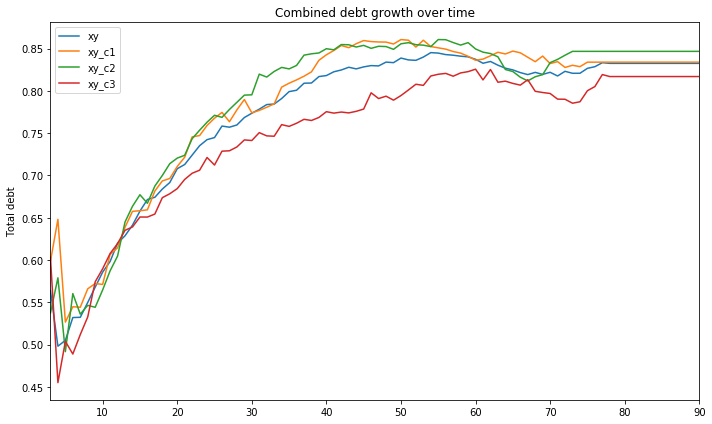

In [20]:
 # fig, ax = plt.subplots(figsize=(5, 3))
fig, ax = plt.subplots(figsize=(10, 6))
# ax.stackplot(yrs, rng + rnd, labels=['Eastasia', 'Eurasia', 'Oceania'])
ax.plot([el[0] for el in xy], [el[1] for el in xy], label='xy')
ax.plot([el[0] for el in xy_c[0]], [el[1] for el in xy_c[0]], label='xy_c1')
ax.plot([el[0] for el in xy_c[1]], [el[1] for el in xy_c[1]], label='xy_c2')
ax.plot([el[0] for el in xy_c[2]], [el[1] for el in xy_c[2]], label='xy_c3')
ax.set_title('silhouette_score per n cluster')
ax.legend(loc='upper left')
ax.set_ylabel('Total debt')
ax.set_xlim(xmin=3, xmax=90)#(xmin=n_clusters[0], xmax=n_clusters[-1])
fig.tight_layout()
 
plt.show()

In [26]:
# avg
labels_avg = []

for i in range(len(list_of_vectorized_frame[0])):
    clusterer = KMeans(n_clusters=best[1])
    data = [x[i] for x in list_of_vectorized_frame]
    labels_avg.append(clusterer.fit_predict(data))
    
labels_by_columns = []
for i in range(len(list_of_vectorized_frame[0])):
    n = best_by_column[i][1]
    clusterer = KMeans(n_clusters=n)
    data = [x[i] for x in list_of_vectorized_frame]
    labels_by_columns.append(clusterer.fit_predict(data))

In [37]:
print(df[df.columns[0]][0], df[df.columns[1]][0], df[df.columns[2]][0])
print(labels_avg[0][0], labels_avg[0][1], labels_avg[0][2])

abide abode abode
6 32 38


### merged test

In [42]:
merged = [x[0] + x[1] + x[2] for x in list_of_vectorized_frame]

In [46]:
len(merged[0]), len(list_of_vectorized_frame[0][0]) * 3

(207, 207)

In [48]:
n_clusters = range(3, int(len(merged) * 0.5))

xy = []
best = (-1.0, -1)

for n in n_clusters:
    clusterer = KMeans(n_clusters=n)
    cluster_labels = clusterer.fit_predict(merged)

    silhouette_avg = silhouette_score(merged, cluster_labels)
    
    if silhouette_avg > best[0]:
        best = (silhouette_avg, n)
    
    xy.append((n, silhouette_avg))
    
print(best)

(0.7332295815864758, 74)


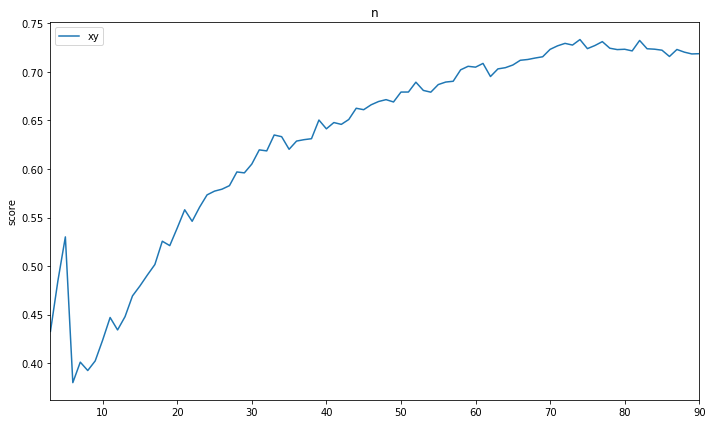

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot([el[0] for el in xy], [el[1] for el in xy], label='xy')
ax.set_title('n')
ax.legend(loc='upper left')
ax.set_ylabel('score')
ax.set_xlim(xmin=3, xmax=90)#(xmin=n_clusters[0], xmax=n_clusters[-1])
fig.tight_layout()
 
plt.show()

In [50]:
n = best[1]
clusterer = KMeans(n_clusters=n)
labels = clusterer.fit_predict(merged)

In [57]:
# res = {labels[i]: (df[df.columns[0]][i], df[df.columns[1]][i], df[df.columns[2]][i]) 
#        for i in range(len(labels))}
res = defaultdict(list)
for i, label in enumerate(labels):
    res[label].append((df[df.columns[0]][i], df[df.columns[1]][i], df[df.columns[2]][i]))

In [54]:
res.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73])

In [62]:
text = ''
for n in res.keys():
    print('cluster {0}'.format(n))
    text += 'cluster {0}'.format(n) + '\n'
    for el in res[n]:
        print('\t{0} - {1} - {2}'.format(el[0], el[1], el[2]))
        text += '\t{0} - {1} - {2}'.format(el[0], el[1], el[2]) + '\n'
    print('-'*70)
    text += '-'*70 + '\n'

cluster 0
	forsake - forsook - forsaken
	mistake - mistook - mistaken
	retake - retook - retaken
	shake - shook - shaken
	take - took - taken
----------------------------------------------------------------------
cluster 1
	beset - beset - beset
	bet - bet - bet
	broadcast - broadcast - broadcast
	burst - burst - burst
	bust - bust - bust
	cast - cast - cast
	cost - cost - cost
	cut - cut - cut
	forecast - forecast - forecast
	hit - hit - hit
	hurt - hurt - hurt
	input - input - input
	inset - inset - inset
	knit - knit - knit
	lead - led - led
	let - let - let
	miscast - miscast - miscast
	misread - misread - misread
	outbid - outbid - outbid
	output - output - output
	put - put - put
	read - read - read
	recast - recast - recast
	reset - reset - reset
	rid - rid - rid
	set - set - set
	shed - shed - shed
	shred - shred - shred
	shut - shut - shut
	slit - slit - slit
	split - split - split
	spread - spread - spread
	sublet - sublet - sublet
	thrust - thrust - thrust
	underbid - underb

In [59]:
res[0]

[('forsake', 'forsook', 'forsaken'),
 ('mistake', 'mistook', 'mistaken'),
 ('retake', 'retook', 'retaken'),
 ('shake', 'shook', 'shaken'),
 ('take', 'took', 'taken')]

In [64]:
with open('ResultEng1.txt', 'w') as f:
    f.write(text)